***IMPORTS***

In [82]:
!pip install emoji
!pip install pyspellchecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 34.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.cuda

from tqdm.notebook import tqdm

torch.manual_seed(1)

In [86]:
import re
import string
import emoji

from spellchecker import SpellChecker
spell = SpellChecker()

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

In [85]:
nltk.download("punkt")
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


***LOADING THE DATASETS***

In [69]:
!gdown --id 1foE1JuZJeu5E_4qVge9kExzhvF32teuF
!gdown --id 13IWXrTjGTrfCd9l7dScZVO8ZvMicPU75

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1foE1JuZJeu5E_4qVge9kExzhvF32teuF
To: /content/tripadvisor_hotel_reviews_reduced.csv
100% 7.36M/7.36M [00:00<00:00, 314MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=13IWXrTjGTrfCd9l7dScZVO8ZvMicPU75
To: /content/scifi_reduced.txt
100% 43.1M/43.1M [00:00<00:00, 200MB/s]


In [70]:
# Loading the trip advisor hotel reviews dataset into a dataframe

df_trip = pd.read_csv("tripadvisor_hotel_reviews_reduced.csv")

In [71]:
# Loading the sci-fi dataset into a dataframe

with open(f'scifi_reduced.txt') as f:
    scifi_txt = f.read()

scifi_txt = scifi_txt.split('. ')

# Loading the sci-fi dataset into a dataframe
df_scifi = pd.DataFrame(scifi_txt, columns=['text'])

***EXPLORATORY DATA ANALYSIS (EDA)***

*Trip Advisor Hotel Reviews Data*

In [72]:
# Info about the dataframe

df_trip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  10000 non-null  object
 1   Rating  10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [73]:
# First few rows of the dataframe

df_trip.head()

,Review,Rating
0,fantastic service large hotel caters business ...,5
1,"great hotel modern hotel good location, locate...",4
2,3 star plus glasgowjust got 30th november 4 da...,4
3,nice stayed hotel nov 19-23. great little bout...,4
4,great place wonderful hotel ideally located me...,5


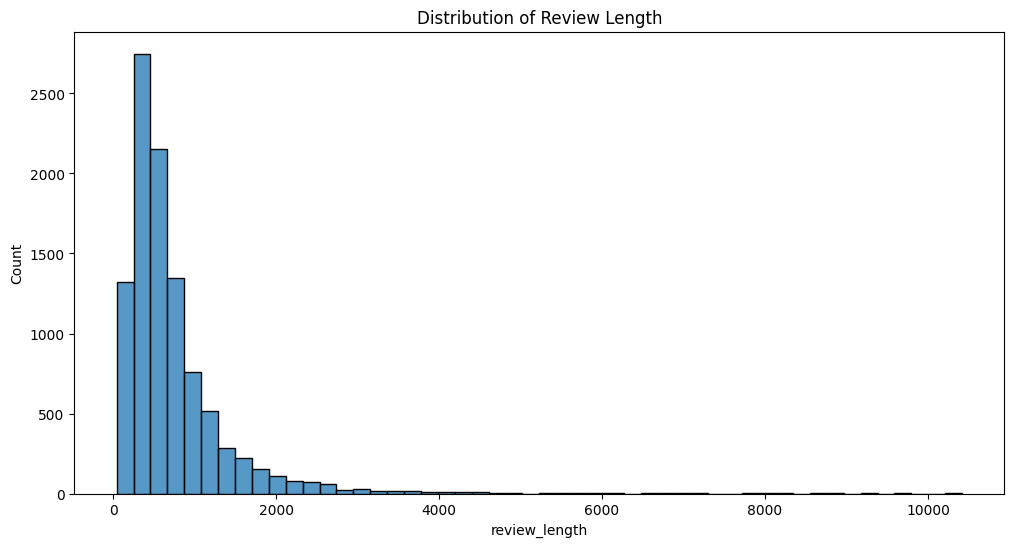

In [74]:
# Visualizing the distribution of length of the reviews

df_trip['review_length'] = df_trip['Review'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(df_trip['review_length'], bins=50)
plt.title('Distribution of Review Length')
plt.show()

In [75]:
df_trip["review_length"].describe()

count    10000.000000
mean       730.082200
std        699.132521
min         44.000000
25%        340.750000
50%        540.000000
75%        859.000000
max      10420.000000
Name: review_length, dtype: float64

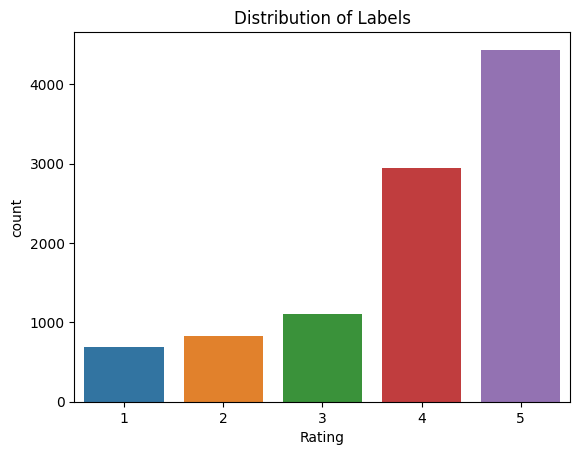

In [76]:
# Distribution of Labels

sns.countplot(x='Rating', data=df_trip)
plt.title('Distribution of Labels')
plt.show()

In [77]:
# Group by labels and describe review length statistics

print(df_trip.groupby('Rating')['review_length'].describe())

         count        mean         std   min     25%    50%     75%      max
Rating                                                                      
1        687.0  775.365357  718.289123  77.0  346.50  553.0  953.00   6511.0
2        828.0  853.996377  743.229338  74.0  411.75  643.5  998.50   7802.0
3       1108.0  792.102888  732.871652  55.0  374.75  590.5  929.50   9339.0
4       2941.0  745.359062  734.636714  61.0  335.00  544.0  883.00   9712.0
5       4436.0  674.320559  648.036990  44.0  324.00  503.5  788.25  10420.0


*Sci-Fi Data*

In [78]:
# Info about the dataset

df_scifi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502462 entries, 0 to 502461
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    502462 non-null  object
dtypes: object(1)
memory usage: 3.8+ MB


In [79]:
# First few rows of the dataframe

df_scifi.head()

,text
0,A chat with the editor i # science fiction ...
1,The title was selected after much thought beca...
2,The tentative title that just morning and coul...
3,A great deal of thought and effort lias gone i...
4,We have had the aid of several very talented a...


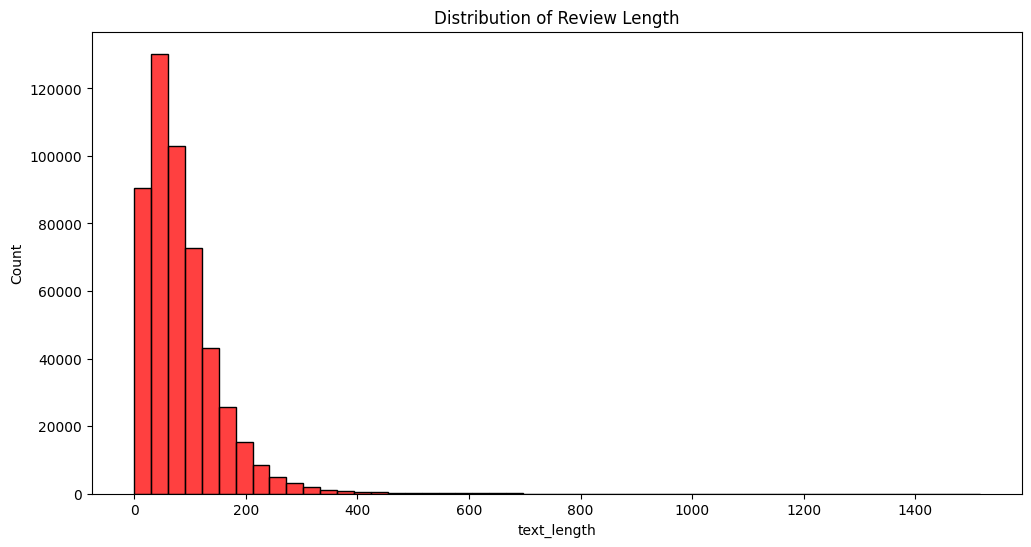

In [80]:
# Visualizing the distribution of length of the reviews

df_scifi['text_length'] = df_scifi['text'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(df_scifi['text_length'], bins=50, color='red')
plt.title('Distribution of Review Length')
plt.show()

In [81]:
df_scifi["text_length"].describe()

count    502462.000000
mean         83.703273
std          64.867403
min           0.000000
25%          38.000000
50%          68.000000
75%         112.000000
max        1515.000000
Name: text_length, dtype: float64

***DATA PREPROCESSING***

In [87]:
# Define a function to correct spelling mistakes in a string
def correct_spelling(text):
    words = text.split()
    corrected_words = []
    for word in words:
        corrected_word = spell.correction(word)
        if corrected_word != None:
          corrected_words.append(corrected_word)
        # print(corrected_word)
    corrected_text = ' '.join(corrected_words)
    return corrected_text

In [88]:
abbreviations = {
    "w/": "with",
    "w/o": "without",
    "msg": "message",
    "u": "you",
    "r": "are",
    "lol": "laughing out loud",
    "np": "no problem",
    "LOL": "laughing out loud",
    "XD" : "laugh",
    "omg" : "oh my god",
    "OMG" : "oh my god",
    "xd" : "laugh"
}

# Define a function to correct abbreviations in a string
def correct_abbreviations(text, abbreviations):
    words = text.split()
    corrected_words = []
    for word in words:
        if word in abbreviations:
            corrected_word = abbreviations[word]
            corrected_words.append(corrected_word)
        else:
            corrected_words.append(word)
    corrected_text = ' '.join(corrected_words)
    return corrected_text

In [94]:
def preprocess_review(review):
  # Convert all words to lower case
  review = review.lower()

  # Remove all punctuations
  review = review.translate(str.maketrans('', '', string.punctuation))

  # Remove all stop words
  # Tokenize the sentence
  tokens = nltk.word_tokenize(review)
  # Remove stop words
  clean_tokens = [token for token in tokens if not token.lower() in stop_words]
  # Join the tokens back into a sentence
  review = ' '.join(clean_tokens)

  # Removing HTML Tags, URLs and Website Links
  # Removing Website Links
  temp_text = review.split()

  for i in temp_text:
    if i[-4:] == ".com" or i[:4] == "www.":
      temp_text.remove(i)

  review = ' '.join(temp_text)

  # Remove HTML tags
  clean_text = re.sub('<[^<]+?>', '', review)

  # Remove URLs
  clean_text = re.sub(r'http\S+', '', clean_text)

  review = clean_text

  # Remove numbers
  review = re.sub(r'\d+', '', review)

  # Deemojize Emojis
  review = emoji.demojize(review)

  # Correct Abbreviations
  # review = correct_abbreviations(review, abbreviations)

  # Remove mentions
  review = re.sub(r'@\w+', '', review)

  # Stemming
  # Tokenize the sentence
  tokens = nltk.word_tokenize(review)

  # Stem the tokens
  stemmed_tokens = [stemmer.stem(token) for token in tokens]

  # Join the stemmed tokens back into a sentence
  review = ' '.join(stemmed_tokens)

    # Spellcheck
  # try:
  #   review = correct_spelling(review)
  # except Exception as e:
  #   print(e)

  return review

***PREPROCESSING THE DATASETS***

*Trip Advisor Hotel Reviews Data*

In [95]:
df_trip["preprocessed_reviews"] = df_trip["Review"].apply(preprocess_review)

In [101]:
cols = list(df_trip.columns.values)
cols

['Review', 'Rating', 'review_length', 'preprocessed_reviews']

In [102]:
df_trip = df_trip[['Review', 'preprocessed_reviews', 'Rating', 'review_length']]

In [103]:
df_trip.head()

,Review,preprocessed_reviews,Rating,review_length
0,fantastic service large hotel caters business ...,fantast servic larg hotel cater busi corpor se...,5,371
1,"great hotel modern hotel good location, locate...",great hotel modern hotel good locat locat minu...,4,297
2,3 star plus glasgowjust got 30th november 4 da...,star plu glasgowjust got th novemb day visit g...,4,319
3,nice stayed hotel nov 19-23. great little bout...,nice stay hotel nov great littl boutiqu hotel ...,4,425
4,great place wonderful hotel ideally located me...,great place wonder hotel ideal locat metro sta...,5,285




---



In [ ]:
word_to_ix = {"hello": 0, "world": 1}
embeds = nn.Embedding(2, 5)  # 2 words in vocab, 5 dimensional embeddings
lookup_tensor = torch.tensor([word_to_ix["hello"]], dtype=torch.long)
hello_embed = embeds(lookup_tensor)
print(hello_embed)

tensor([[ 0.6614,  0.2669,  0.0617,  0.6213, -0.4519]],
       grad_fn=<EmbeddingBackward>)


# An Example: N-Gram Language Modeling

Recall that in an n-gram language model, given a sequence of words
$w$, we want to compute

\begin{align}P(w_i | w_{i-1}, w_{i-2}, \dots, w_{i-n+1} )\end{align}

Where $w_i$ is the ith word of the sequence.

In this example, we will compute the loss function on some training
examples and update the parameters with backpropagation.




In [ ]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10
# We will use Shakespeare Sonnet 2
test_sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".split()
# we should tokenize the input, but we will ignore that for now
# build a list of tuples.  Each tuple is ([ word_i-2, word_i-1 ], target word)
trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
            for i in range(len(test_sentence) - 2)]
# print the first 3, just so you can see what they look like
print(trigrams[:3])

vocab = set(test_sentence)
word_to_ix = {word: i for i, word in enumerate(vocab)}


class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

for epoch in range(10):
    total_loss = 0
    for context, target in trigrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)
print(losses)  # The loss decreased every iteration over the training data!

[(['When', 'forty'], 'winters'), (['forty', 'winters'], 'shall'), (['winters', 'shall'], 'besiege')]
[520.3871965408325, 517.7946381568909, 515.2209987640381, 512.6648173332214, 510.1252510547638, 507.5997726917267, 505.0876843929291, 502.5877056121826, 500.10036849975586, 497.62375688552856]


# Exercise: Computing Word Embeddings: Continuous Bag-of-Words

The Continuous Bag-of-Words model (CBOW) is frequently used in NLP deep
learning. It is a model that tries to predict words given the context of
a few words before and a few words after the target word. This is
distinct from language modeling, since CBOW is not sequential and does
not have to be probabilistic. Typcially, CBOW is used to quickly train
word embeddings, and these embeddings are used to initialize the
embeddings of some more complicated model. Usually, this is referred to
as *pretraining embeddings*. It almost always helps performance a couple
of percent.

The CBOW model is as follows. Given a target word $w_i$ and an
$N$ context window on each side, $w_{i-1}, \dots, w_{i-N}$
and $w_{i+1}, \dots, w_{i+N}$, referring to all context words
collectively as $C$, CBOW tries to minimize

\begin{align}-\log p(w_i | C) = -\log \text{Softmax}(A(\sum_{w \in C} q_w) + b)\end{align}

where $q_w$ is the embedding for word $w$.

Implement this model in Pytorch by filling in the class below. Some
tips:

* Think about which parameters you need to define.
* Make sure you know what shape each operation expects. Use .view() if you need to
  reshape.




In [ ]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(raw_text)
vocab_size = len(vocab)

word_to_ix = {word: i for i, word in enumerate(vocab)}
data = []
for i in range(2, len(raw_text) - 2):
    context = [raw_text[i - 2], raw_text[i - 1],
               raw_text[i + 1], raw_text[i + 2]]
    target = raw_text[i]
    data.append((context, target))
print(data[:5])


class CBOW(nn.Module):

    def __init__(self):
        pass

    def forward(self, inputs):
        pass

# create your model and train.  here are some functions to help you make
# the data ready for use by your module


def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)


make_context_vector(data[0][0], word_to_ix)  # example